# Lab3: Optimization II (Pyomo) (Solution)

University of California Berkeley

ME C231A, EE C220B, Experiential Advanced Control I

***

In the previous lab, you formulated and solved linear and quadratic optimization problems using $\texttt{cvxopt}$ and $\texttt{cvxpy}$. In this lab we will introduce $\texttt{Pyomo}$ (Python Optimization Modeling Objects), a mathematical modeling toolboxe, which facilitates the task of defining/formulating the optimization problems. For more information look at this link: https://pyomo.readthedocs.io/en/stable/pyomo_overview/index.html

In this lab we will solve linear, quaratic, nonlinear and mixed-integer programming using $\texttt{Pyomo}$.

In [32]:
# This cell is commented out because Pyomo and solvers are already installed on Docker image.
# Please run this cell only if you are using Google Colab. 

# # install required dependencies
# import sys
# IN_COLAB = 'google.colab' in sys.modules
# if IN_COLAB:
#   !pip install -q pyomo
#   !apt-get install -y -qq glpk-utils
#   !apt-get install -y -qq coinor-cbc
#   !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
#   !unzip -o -q ipopt-linux64

***

# Linear Programming Exercise

In the previous lab, we solved the following LP using $\texttt{cvxopt}$. Now we solve the same problem using $\texttt{Pyomo}$.

Let $x,y,z\in\mathbb{R}$. Use $\texttt{Pyomo}$ to solve the following problem.
\begin{align}
\min_{x,y,z}\ & x+y+z\\
\text{subject to} & -2\le x\\
&-1\le y\\
&-3\le z\\
&x-y+z\ge 4
\end{align}


To use $\texttt{Pyomo}$, first declare the model, next define the variables, the constraints and the objective, and finally solve the optimization. You can use most basic $\texttt{python}$ functions in your constraint and cost definitions.

In [33]:
import pyomo.environ as pyo

model = pyo.ConcreteModel()
model.x = pyo.Var()
model.y = pyo.Var()
model.z = pyo.Var()

model.Obj = pyo.Objective(expr = model.x + model.y + model.z)
model.Constraint1 = pyo.Constraint(expr = -2 <= model.x)
model.Constraint2 = pyo.Constraint(expr = -1 <= model.y)
model.Constraint3 = pyo.Constraint(expr = -3 <= model.z)
model.Constraint4 = pyo.Constraint(expr = model.x - model.y + model.z >= 4)

solver = pyo.SolverFactory('cbc')
results = solver.solve(model)
model.display()

print('x*_solver =', pyo.value(model.x))
print('y*_solver =', pyo.value(model.y))
print('z*_solver =', pyo.value(model.z))
print('opt_value =', pyo.value(model.Obj))

Model unknown

  Variables:
    x : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :   6.0 :  None : False : False :  Reals
    y : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :  -1.0 :  None : False : False :  Reals
    z : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :  -3.0 :  None : False : False :  Reals

  Objectives:
    Obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True :   2.0

  Constraints:
    Constraint1 : Size=1
        Key  : Lower : Body : Upper
        None :  -2.0 :  6.0 :  None
    Constraint2 : Size=1
        Key  : Lower : Body : Upper
        None :  -1.0 : -1.0 :  None
    Constraint3 : Size=1
        Key  : Lower : Body : Upper
        None :  -3.0 : -3.0 :  None
    Constraint4 : Size=1
        Key  : Lower : Body : Upper
        None :   4.0 :  4.0 :  Non

***

# Nonlinear Programming Example
We will use using $\texttt{Pyomo}$ to sovle the following optimization problem:

\begin{align}
\min_{z_1,z_2}~ & 3\sin(-2\pi z_1)+2z_1+4+\cos(2\pi z_2)+z_2 \\
\text{s.t. } &-1 \leq z_1 \leq 1 \\
&-1 \leq z_2 \leq 1
\end{align}
Next we denote $\texttt{z0}$  the initial guess for your optimizer, $\texttt{zOpt}$ the optimizer and $\texttt{JOpt}$ is the optimal cost.


In [34]:
import numpy as np
import pyomo.environ as pyo
from pyomo.opt import SolverStatus, TerminationCondition

## without initialization:

model = pyo.ConcreteModel()
model.z1 = pyo.Var()
model.z2 = pyo.Var()
model.obj = pyo.Objective(expr = 3*pyo.sin(-2*np.pi*model.z1)+ 2*model.z1 + 4 + pyo.cos(2*np.pi*model.z2) + model.z2)
model.constraint1 = pyo.Constraint(expr = (-1, model.z1, 1))
model.constraint2 = pyo.Constraint(expr = (-1, model.z2, 1))
# model.constraint2 = pyo.Constraint(expr = pyo.inequality(-1, model.z2, 1))  #This line and the above line are equivalent. 
# Range inequlities can be represented using both the above syntaxes.

solver = pyo.SolverFactory('ipopt')
results = solver.solve(model)

print('zOpt = ', np.array([pyo.value(model.z1), pyo.value(model.z2)]))
print('JOpt = ', pyo.value(model.obj))


zOpt =  [ 0.23308129 -0.52543847]
JOpt =  -0.02959484805254975


Next we solve the optimization for 10 random initial guesses, drawing them from a uniform random distribution across your feasible set.

In [35]:
## With random initialization:
# If the initialization is way off, the solver can't find a solution.

z1 = []
z2 = []
J = []
solver = pyo.SolverFactory('ipopt')

for _ in range(10):
    z1_init = np.random.uniform(low = -1.0, high = 1.0)
    z2_init = np.random.uniform(low = -1.0, high = 1.0)
    model = pyo.ConcreteModel()
    model.z1 = pyo.Var(initialize = z1_init)
    model.z2 = pyo.Var(initialize = z2_init)
    model.obj = pyo.Objective(expr = 3*pyo.sin(-2*np.pi*model.z1) + 2*model.z1 + 4 + pyo.cos(2*np.pi*model.z2) + model.z2)
    model.constraint1 = pyo.Constraint(expr = (-1, model.z1, 1))
    model.constraint2 = pyo.Constraint(expr = (-1, model.z2, 1))
    results = solver.solve(model)
    zOpt = np.array([pyo.value(model.z1), pyo.value(model.z2)])
    JOpt = pyo.value(model.obj)
    z1.append(zOpt[0])
    z2.append(zOpt[1])
    J.append(JOpt)
    
print('z1Opt=', z1)
print('z2Opt=', z2)
print('opt_value=', J)

z1Opt= [-0.7669187105942515, 0.2330812893159912, 0.2330812893159912, -0.7669187105942515, -0.7669187105942515, 0.2330812893159912, 0.23308128931599117, 0.2330812893159912, 0.23308128931599117, -0.7669187105942517]
z2Opt= [-0.5254384707730885, -0.5254384707730885, 0.4745615290547882, 0.47456152905478827, -0.5254384707730885, -0.5254384707730885, -0.5254384707730885, 0.47456152905478827, -0.5254384707730885, 0.4745615290547882]
opt_value= [-2.02959484805255, -0.029594848052550193, 0.9704051519474498, -1.0295948480525496, -2.02959484805255, -0.029594848052550193, -0.02959484805254975, 0.9704051519474499, -0.02959484805254975, -1.0295948480525496]


Now we print out a plot of the cost function contour and mark out the initial guesses and the optimal solutions.

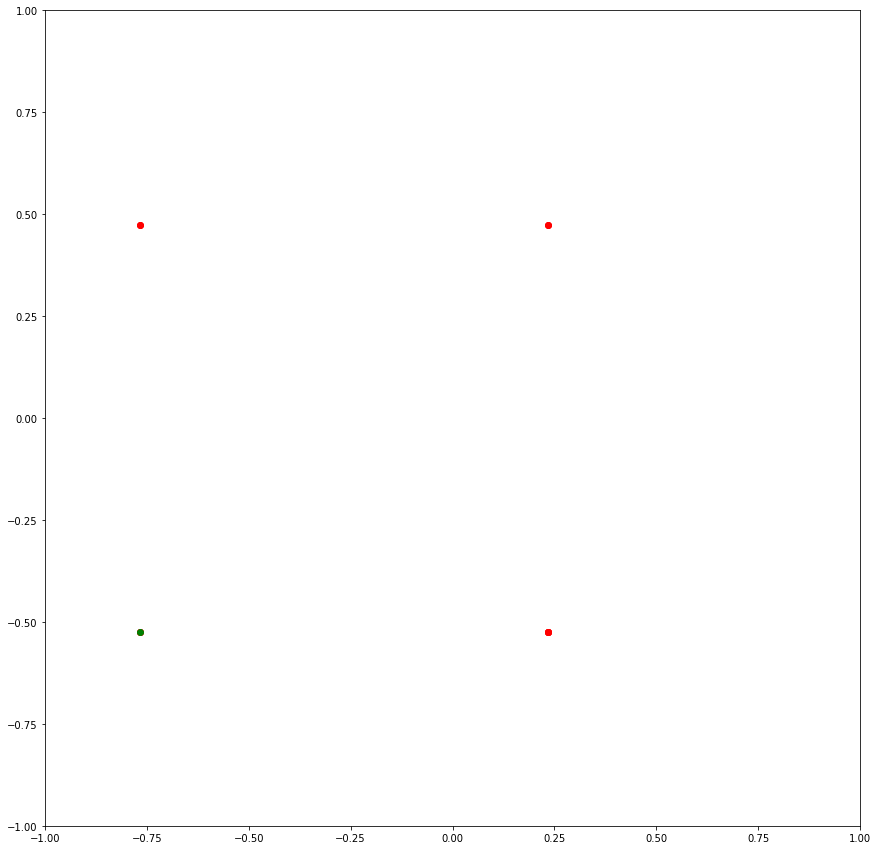

In [36]:
import matplotlib.pyplot as plt
# import copy

z1_opt = z1
z2_opt = z2

fig, ax = plt.subplots(figsize=(15,15))
z = np.linspace(-1, 1, 100)
z1, z2 = np.meshgrid(z, z)
C = 3*np.sin(-2*np.pi*z1)+ 2*z1 + 4 + np.cos(2*np.pi*z2) + z2
contour = ax.contour(z1, z2, C, cmap=plt.cm.RdBu, vmin=abs(C).min(), vmax=abs(C).max(), levels=30)
ax.clabel(contour,fontsize=12, inline=1)
ax.axis('square')
ax.scatter(np.asarray(z1_opt), np.asarray(z2_opt) , c='r', marker='o')
ax.axis('square')
# ax.scatter(zOpt[0], zOpt[1] , c='g', marker='o')
ax.scatter(z1_opt[4], z2_opt[4] , c='g', marker='o')
plt.show()

***

# Mixed-Integer Programming Example 
extracted from https://yalmip.github.io/example/unitcommitment/

A classical problem in scheduling and integer programming is the unit commitment problem. In this problem, our task is to turn on and off power generating plants, in order to meet a forecasted future power demand, while minimizing our costs. 

We have three different power plants with different characteristics and running costs, and various constraints on how they can be used. 

The most important thing we learn in this example is that you never multiply binary variables with continuous variables to model on/off behavior. Instead, we derive equivalent linear presentations.

### Data for the model
To begin with, we assume we have $N=3$ power generating plants of different types (nuclear, hydro, gas, oil, coal, …). Each of the plant $i$ have a maximum power capacity $P^{max}_i$, and a minimum capacity $P^{min}_i$, when turned on. Our scheduling problem is solved over 48 time units (say hours), and the forecasted power demand is given by a periodic function. The cost of running plant $i$ for one time unit is given by a linear function $C_iP_i$ where $P_i$ is the delivered power from plant $i$.

Next we use $\texttt{pyomo}$ to formulate a mathematical model for the optimization problem. we first declare the model, next we define the variables, the constraints and the objective, and finally we solve the optimization. 

100


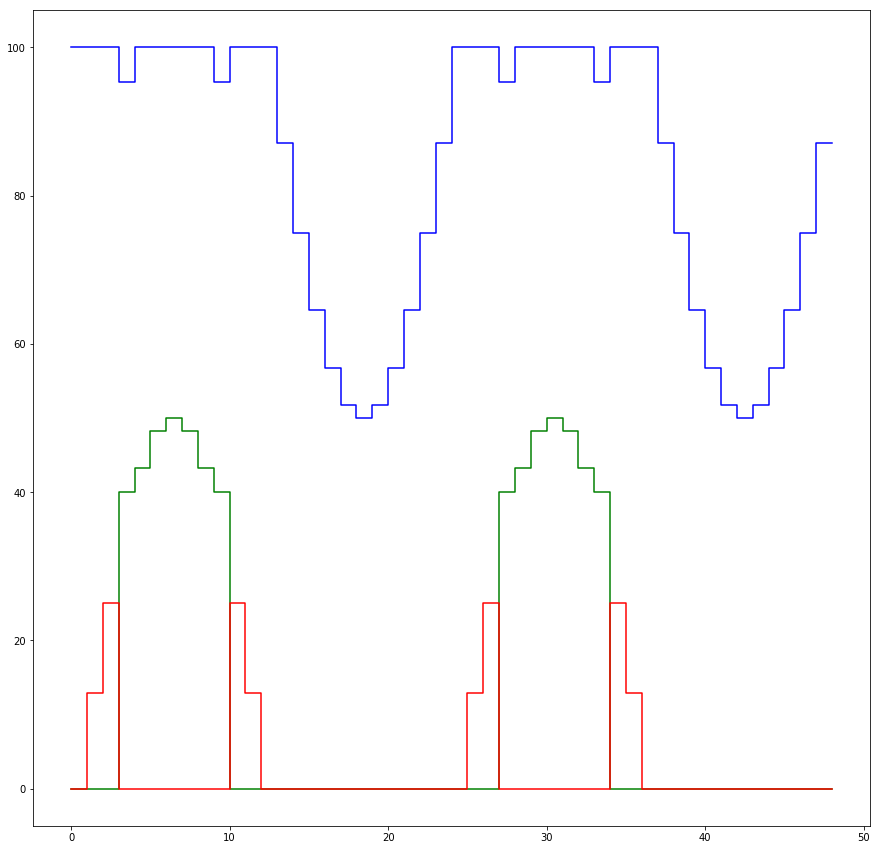

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pyomo.environ as pyo

Horizon = 48
T = np.array([t for t in range(0, Horizon)])

#predicted demand
d = np.array([100 + 50*np.sin(t*2*np.pi/24) for t in T])

#problem data
Nplant = 3
N = np.array([n for n in range(0, Nplant)])
pmax = [100, 50, 25]
pmin = [20, 40, 1]
C = [10, 20, 20]

model = pyo.ConcreteModel()
model.N = pyo.Set(initialize = N)
model.T = pyo.Set(initialize = T)
# print(max(pmax))

# x[i,t]= production of plant i at time t
model.x = pyo.Var(model.N, model.T)

# x[i,t]= on/of plant i at time t
model.u = pyo.Var(model.N, model.T, domain = pyo.Binary)

# objective
model.cost = pyo.Objective(expr = sum(model.x[n,t]*C[n] for t in model.T for n in model.N), sense = pyo.minimize)

# demand constraints
model.demand = pyo.Constraint(model.T, rule=lambda model, t: sum(model.x[n,t] for n in N) >= d[t])

# production constraints # NOTE LINEAR IN  x AND u
model.lb = pyo.Constraint(model.N, model.T, rule=lambda model, n, t: pmin[n]*model.u[n,t] <= model.x[n,t])
model.ub = pyo.Constraint(model.N, model.T, rule=lambda model, n, t: pmax[n]*model.u[n,t] >= model.x[n,t])
   
# solve
solver = pyo.SolverFactory('glpk')
results = solver.solve(model)

# plot results
Unit1=[pyo.value(model.x[0,0])]
Unit2 = [pyo.value(model.x[1,0])]
Unit3 = [pyo.value(model.x[2,0])]
for t in T:
    Unit1.append(pyo.value(model.x[0,t]))
    Unit2.append(pyo.value(model.x[1,t]))
    Unit3.append(pyo.value(model.x[2,t]))
plt.figure(figsize = (15,15))
plt.step(Unit1,'b')
plt.step(Unit2,'g')
plt.step(Unit3,'r')
plt.show()

***

# Quadratic Programming Exercise
Consider a single-input single-output dynamic system described by the discrete-time state-space equation $x_{k+1} = 0.5 x_k + u_k$, with given initial condition $x_0$.  We wish to choose a control input sequence $u_0,u_1$ that satisfies constraints
on the state $x_1 \in [2,5]$, $x_2 \in [-2,2]$ and input $u_0,u_1 \in [-1,1]$ while minimizing a given quadratic performance index.

We can formulate this problem as the following optimization problem: For a given value of $x_0$
\begin{align*}
J(x_0) := \min_{x_1, x_2,u_0,u_1} \ & \ \frac{1}{2}(x_1^2+x_2^2+u_0^2+u_1^2)\\
\text{subject to} \ & \ x_1 = 0.5 x_0 + u_0 \\
&\ x_2 = 0.5 x_1 + u_1 \\
&\ 2 \leq x_1\leq 5\\
& -2 \leq x_2\leq 2 \\
& -1 \leq u_0\leq 1\\
& -1\leq u_1\leq 1
\end{align*}
Solve this problem using $\texttt{pyomo}$. 

In [38]:
# Pyomo version

import numpy as np
import pyomo.environ as pyo

x0 = 10.0

model = pyo.ConcreteModel()

model.idxx = pyo.Set(initialize = [0, 1])
model.idxu = pyo.Set(initialize = [0, 1])
model.x = pyo.Var(model.idxx)  
model.u = pyo.Var(model.idxu) 

obj_expr = 0.5*(model.x[0]**2 + model.x[1]**2 + model.u[0]**2 + model.u[1]**2)
model.OBJ = pyo.Objective(expr = obj_expr, sense=pyo.minimize)   # define the objective 

model.cons = pyo.ConstraintList()
model.cons.add(model.x[0] == 0.5*x0 + model.u[0])
model.cons.add(model.x[1] == 0.5*model.x[0] + model.u[1])
model.cons.add(pyo.inequality(lower=2, body=model.x[0],  upper=5))
model.cons.add(pyo.inequality(-2, model.x[1], 2))
model.cons.add(pyo.inequality(-1, model.u[0], 1))
model.cons.add(pyo.inequality(-1, model.u[1], 1))

results = pyo.SolverFactory('ipopt').solve(model).write()
# model.display()

xstar_pyo = np.array([model.x[t]() for t in model.idxx])
print('x*_solver=', xstar_pyo)
print('opt_value=', pyo.value(model.OBJ))

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 6
  Number of variables: 4
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.5.5\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.021996498107910156
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Model un